It could be that the coordinate system we get everything in, is actually the one from the Top View. 

In [1]:
from utils import (
    load_dataset,
    get_images,
    transform_points,
    predict,
    SCALING_FACTOR
)
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
filename = 'mini3.json'

with open(filename, 'r') as file:
    data = json.load(file)
K = data['mtx']
dist = data['dist']
K = np.array(K)
dist = np.array(dist)

In [3]:
from scipy.spatial.transform import Rotation as SpicyR
def get_pose(pv_img):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, 'DJI_0017')
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    
    h, _ = cv2.findHomography(
        reference_pts_pv_arr,
        reference_pts_tv_arr,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)

    H = h_inv.T
    h1 = H[0]
    h2 = H[1]
    h3 = H[2]
    K_inv = np.linalg.inv(K)
    L = 1 / np.linalg.norm(np.dot(K_inv, h1))
    h1, h2, h3 = h1*L, h2*L, h3*L
    #r1 = L * np.dot(K_inv, h1)
    #r2 = L * np.dot(K_inv, h2)
    r1 = np.dot(K_inv, h1)
    r2 = np.dot(K_inv, h2)
    r3 = np.cross(r1, r2)
    #T = L * (K_inv @ h3.reshape(3, 1))
    T = K_inv @ h3.reshape(3, 1)
    R = np.array([[r1], [r2], [r3]])
    R = np.reshape(R, (3, 3))
    T = -R@T
    rotation = SpicyR.from_matrix(R)
    euler_angles = rotation.as_euler('xyz', degrees=True)
    roll, pitch, yaw = euler_angles
    return roll-90, T
pitch, position = get_pose('DJI_0026')
print(pitch)

-40.45333045952798


In [4]:
gt_pitches = [-92.0, -43.0, -43.0, -43.0, -43.0, -38.1, -27.8, -38.5, -32.1, -43.5, -38.7, -47.3, -36.8]

In [5]:
pitches, positions = [], []
for fname, gt in zip(['DJI_0017', 'DJI_0026', 'DJI_0029', 'DJI_0032', 'DJI_0035', 'DJI_0038', 'DJI_0045', 'DJI_0049', 'DJI_0053', 'DJI_0061', 'DJI_0066', 'DJI_0067', 'DJI_0078'],
                 gt_pitches):
    pitches.append(pitch)
    positions.append(position)
    pitch, position = get_pose(fname)
    print(fname, pitch, gt, '----', position.T)

DJI_0017 -90.00000000000003 -92.0 ---- [[ 1972.90578033  1544.40850416 -2817.388054  ]]
DJI_0026 -40.45333045952798 -43.0 ---- [[2709.2125776  1570.45657785 -544.62256893]]
DJI_0029 -40.839033004187904 -43.0 ---- [[2418.31959927 1519.26380072 -580.08996622]]
DJI_0032 -41.716624611522896 -43.0 ---- [[2401.87334672 1449.84136023 -557.17110455]]
DJI_0035 -41.268448050398696 -43.0 ---- [[3288.93516704 1989.47555479 -597.57213606]]
DJI_0038 -36.311466333351724 -38.1 ---- [[3266.1391261  1553.57492437 -562.13368632]]
DJI_0045 -24.28759405024944 -27.8 ---- [[1619.29821409 1032.44219218  146.65548758]]
DJI_0049 -34.872090606215146 -38.5 ---- [[ 567.62912855 1461.26876725 -571.2685677 ]]
DJI_0053 -29.350078871477336 -32.1 ---- [[ 409.19384359  713.12900626 -168.74662054]]
DJI_0061 -40.63861825636793 -43.5 ---- [[1178.73474896  693.51472722 -559.91279103]]
DJI_0066 -35.15194001690583 -38.7 ---- [[2752.45076776  689.82687767 -452.52919797]]
DJI_0067 -44.05596642810838 -47.3 ---- [[2766.93488263  

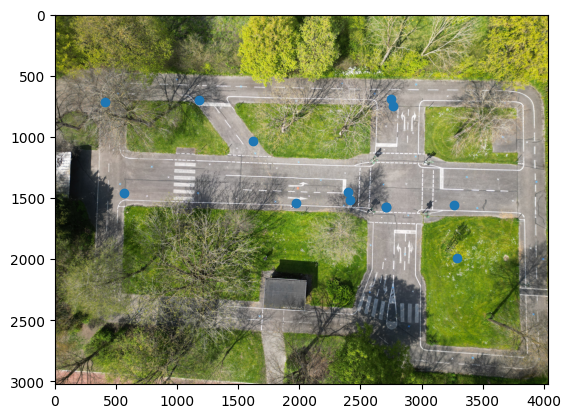

In [6]:
img_pv, img_tv = get_images('DJI_0026', 'DJI_0017')
plt.imshow(img_tv)
positions = np.array(positions)
plt.scatter(positions[:, 0], positions[:, 1])

Now optimization algorithm on top?! what are inputs of the optimization?

#### Experimental

In [45]:
def get_pose(pv_img):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, 'DJI_0017')
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    
    h, _ = cv2.findHomography(
        reference_pts_pv_arr,
        reference_pts_tv_arr,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)

    H = h_inv.T
    h1 = H[0]
    h2 = H[1]
    h3 = H[2]
    K_inv = np.linalg.inv(K)
    # SCALE
    L = 1 / np.linalg.norm(np.dot(K_inv, h1))
    # h1, h2, h3 = h1*L, h2*L, h3*L
    # ROTATION
    r1 = np.dot(K_inv, h1)
    r2 = np.dot(K_inv, h2)
    r1 = r1/np.linalg.norm(r1)
    r2 = r2/np.linalg.norm(r2)
    
    r3 = np.cross(r1, r2)

    #r1 = np.array([r1[0], r1[1], -r1[2]])
    #r2 = np.array([r2[0], r2[1], -r2[2]])
    #r3 = np.array([r3[0], r3[1], -r3[2]])
    
    # TRANSLATION
    T = K_inv @ h3.reshape(3, 1)
    T = T / np.linalg.norm(np.dot(K_inv, h1))
    R = np.array([[r1], [r2], [r3]])
    R = np.reshape(R, (3, 3))
    rotation = SpicyR.from_matrix(R)
    T = -R@T
    euler_angles = rotation.as_euler('xyz', degrees=True)
    roll, pitch, yaw = euler_angles
    roll = roll-90
    
    return roll, T
pitch, position = get_pose('DJI_0026')
print(pitch)

-40.457331123908446


In [58]:
pitches, positions = [], []
for fname, gt in zip(['DJI_0017', 'DJI_0026', 'DJI_0029', 'DJI_0032', 'DJI_0035', 'DJI_0038', 'DJI_0045', 'DJI_0049', 'DJI_0053', 'DJI_0061', 'DJI_0066', 'DJI_0067', 'DJI_0078'],
                 gt_pitches):
    pitches.append(pitch)
    positions.append(position)
    pitch, position = get_pose(fname)
    #print(fname, pitch, gt, '----', f'{position[0][0]:.2f}, {position[1][0]:.2f}, {(position[2][0]/SCALING_FACTOR):.2f}')
    print(f'{pitch:.1f}')

-90.0
-40.5
-41.0
-41.7
-41.8
-36.4
-24.7
-34.9
-29.9
-41.0
-36.2
-44.4
-34.7


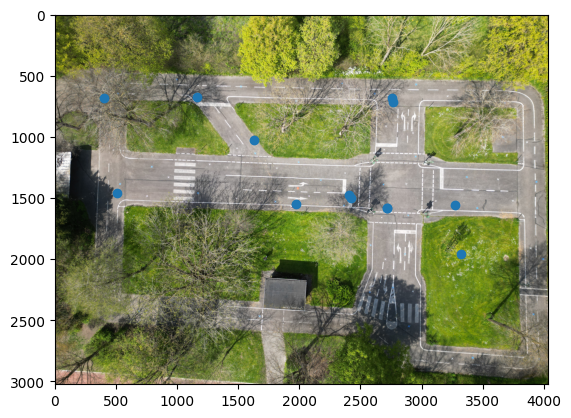

In [32]:
plt.imshow(img_tv)
positions = np.array(positions)
plt.scatter(positions[:, 0], positions[:, 1])

The problem is that you also flipped the x,  y axis...